In [1]:
import glob
import xarray as xr
import pandas as pd
import json

import warnings
warnings.filterwarnings("ignore")

In [2]:
# !pip install jinja2
# !python -m pip install "dask[diagnostics]"
# !pip install netcdf4
# !pip install matplotlib
# !python -m pip install scikit-learn

In [2]:
# Get the list of processed files
input_files = sorted(glob.glob('input/data/*.trf'))
output_files = sorted(glob.glob('output/netCDF/*.nc'))

In [4]:
print('Number of input files:', len(input_files))
print('Number of output files:', len(output_files))

Number of input files: 2037
Number of output files: 1660


In [5]:
input_timestamp_pattern = 'input/data/RD-%Y%m%d-%H%M%S.trf'
output_timestamp_pattern = 'output/netCDF/att01rd80CA.b1.%Y%m%d.%H%M%S.nc'

# First input file stamp
first_input_stamp = pd.to_datetime(input_files[0], format=input_timestamp_pattern)
last_input_stamp = pd.to_datetime(input_files[-1], format=input_timestamp_pattern)
print('First input file:', first_input_stamp, 'Last input file:', last_input_stamp)

# First output file stamp
first_output_stamp = pd.to_datetime(output_files[0], format=output_timestamp_pattern)
last_output_stamp = pd.to_datetime(output_files[-1], format=output_timestamp_pattern)
print('First output file:', first_output_stamp, 'Last output file:', last_output_stamp)

First input file: 2020-03-03 13:19:00 Last input file: 2024-09-16 20:36:00
First output file: 2020-03-03 00:00:00 Last output file: 2024-09-17 00:00:00


#### 1 - Check if algorithm create correct number of netCF files

In [6]:
# Check if outputfiles are missing from the list
full_output_timestamps = pd.date_range(start=first_output_stamp, end=last_output_stamp, freq='1D')
if len(output_files) != len(full_output_timestamps):
    print('Error - Missing output files:', len(full_output_timestamps) - len(output_files))
    missing_output_files = full_output_timestamps[~full_output_timestamps.isin(pd.to_datetime(output_files, format=output_timestamp_pattern))]
    print('Error - Missing output files:', missing_output_files)
else:
    print('OK - All output files are present, with number:', len(output_files))

OK - All output files are present, with number: 1660


##### 2 - Check if algorithm create correct time series into netCF files

In [3]:
# Read all the output files
ouput_ds = xr.open_mfdataset(output_files, combine='nested', concat_dim='time')

In [8]:
# Check if first time stamp is correct
if first_output_stamp.date() == pd.to_datetime(ouput_ds.time[0].values).date():
    print('OK - First output file time stamp is correct')
else:
    print('Error - First output file time stamp is incorrect')
# Check if last time stamp is correct
if last_output_stamp.date() == pd.to_datetime(ouput_ds.time[-1].values).date():
    print('OK - Last output file time stamp is correct')
else:
    print('Error - Last output file time stamp is incorrect')
# Check if the number of time stamps is correct
if len(full_output_timestamps) == len(ouput_ds.time.resample(time='1D').count()):
    print('OK - All output file time stamps are correct')
else:
    print('Error - Some output file time stamps are incorrect')

OK - First output file time stamp is correct
OK - Last output file time stamp is correct
OK - All output file time stamps are correct


##### 3 - Check if algorithm create correct time series between input and output netCF files

In [8]:
from utils.disdrometer_utils import *

with open('input/support/variables_info.json', "r") as xfile:
    variables_info_file = xfile.read()
variables_info = json.loads(variables_info_file)
columns = variables_info['Columns']

# Open input files
input_df = read_files_rd80(input_files, columns=columns)

In [20]:
input_df.index

DatetimeIndex(['2020-03-03 13:19:00', '2020-03-03 13:20:00',
               '2020-03-03 13:21:00', '2020-03-03 13:22:00',
               '2020-03-03 13:23:00', '2020-03-03 13:24:00',
               '2020-03-03 13:25:00', '2020-03-03 13:26:00',
               '2020-03-03 13:27:00', '2020-03-03 13:28:00',
               ...
               '2024-09-19 20:26:00', '2024-09-19 20:27:00',
               '2024-09-19 20:28:00', '2024-09-19 20:29:00',
               '2024-09-19 20:30:00', '2024-09-19 20:31:00',
               '2024-09-19 20:32:00', '2024-09-19 20:33:00',
               '2024-09-19 20:34:00', '2024-09-19 20:35:00'],
              dtype='datetime64[ns]', name='Date_Time', length=2020065, freq=None)

In [38]:
input_unique_timestamp = input_df.index.unique()
input_unique_timestamp = pd.to_datetime(input_unique_timestamp)

print('First timestamp in input_df:', input_unique_timestamp[0])
print('First timestamp in output_ds:', pd.to_datetime(ouput_ds.time[0].values))
print('Last timestamp in input_df:', input_unique_timestamp[-1])
print('Last timestamp in output_ds:', pd.to_datetime(ouput_ds.time[-1].values))
print('-' * 50)
print('Number of timestamp in input_df:', len(input_unique_timestamp))
print('Number of timestamps in output_ds:', len(ouput_ds.time))
print('Number of missing timestamps:', len(ouput_ds.time) - len(input_unique_timestamp))
print('-' * 50)
print('Percentage of missing timestamps:', (len(ouput_ds.time) - len(input_unique_timestamp)) / len(ouput_ds.time) * 100, '%')

First timestamp in input_df: 2020-03-03 13:19:00
First timestamp in output_ds: 2020-03-03 00:00:00
Last timestamp in input_df: 2024-09-19 20:35:00
Last timestamp in output_ds: 2024-09-19 23:59:00
--------------------------------------------------
Number of timestamp in input_df: 2020065
Number of timestamps in output_ds: 2393280
Number of missing timestamps: 373215
--------------------------------------------------
Percentage of missing timestamps: 15.59428900922583 %


In [11]:
valid_df = pd.DataFrame()
# Groupby interval of 1 hour
input_1hour = input_df.groupby(pd.Grouper(freq='1H'))
for tstamp, group in input_1hour:
    time_df = pd.DataFrame({'timestamp': [tstamp]})
    timestmps = group.index
    sel_ds = ouput_ds.sel(time=tstamp.strftime('%Y-%m-%d %H')).compute() # Select the dataset for the timestamp
    time_df['trf_dtype'] = group['RI'].dtype
    time_df['nc_dtype'] = sel_ds['rain_rate'].dtype
    time_df['trf_size'] = len(group) # Number of observations
    time_df['nc_size'] = len(sel_ds['rain_rate']) # Number of observations in the dataset
    # Get variables
    rr_df = group['RI']
    rr_ds = sel_ds['rain_rate'].to_series()
    # count nan
    time_df['trf_ri_nan_count'] = rr_df.isna().sum()
    time_df['nc_ri_nan_count'] = rr_ds.isna().sum()
    # Remove nan to calculate statistics
    rr_df = rr_df.dropna()
    rr_ds = rr_ds.dropna()
    # min and max
    time_df['trf_ri_min'] = rr_df.min()
    time_df['nc_ri_min'] = rr_ds.min()
    time_df['ri_mae'] = np.mean(np.abs(rr_df - rr_ds))
    time_df['ri_max_abs_error'] = np.max(np.abs(rr_df - rr_ds))
    time_df['ri_pearson_corr'] = rr_df.corr(rr_ds)
    # Concatenate the dataframes
    valid_df = pd.concat([valid_df, time_df])

In [12]:
valid_df.to_csv('valid_df.csv', index=False)

In [39]:
valid_df = pd.read_csv('valid_df.csv')

In [41]:
valid_df

,timestamp,trf_dtype,nc_dtype,trf_size,nc_size,trf_ri_nan_count,nc_ri_nan_count,trf_ri_min,nc_ri_min,ri_mae,ri_max_abs_error,ri_pearson_corr
0,2020-03-03 13:00:00,float64,float32,41,60,0,19,0.0,0.0,6.929086e-07,0.000011,1.0
1,2020-03-03 14:00:00,float64,float32,60,60,0,0,0.0,0.0,0.000000e+00,0.000000,NaN
2,2020-03-03 15:00:00,float64,float32,60,60,0,0,0.0,0.0,0.000000e+00,0.000000,NaN
3,2020-03-03 16:00:00,float64,float32,60,60,0,0,0.0,0.0,0.000000e+00,0.000000,NaN
4,2020-03-03 17:00:00,float64,float32,60,60,0,0,0.0,0.0,0.000000e+00,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
39819,2024-09-17 16:00:00,float64,float32,60,60,0,0,0.0,0.0,7.944257e-07,0.000048,1.0
39820,2024-09-17 17:00:00,float64,float32,60,60,0,0,0.0,0.0,0.000000e+00,0.000000,NaN
39821,2024-09-17 18:00:00,float64,float32,60,60,0,0,0.0,0.0,3.947683e-07,0.000012,1.0
39822,2024-09-17 19:00:00,float64,float32,60,60,0,0,0.0,0.0,5.923651e-07,0.000036,1.0


In [53]:
input_df.head(20)

,Status,Interval,n1,n2,n3,n4,n5,n6,n7,n8,...,n14,n15,n16,n17,n18,n19,n20,RI,RA,RAT
Date_Time,,,,,,,,,,,,,,,,,,,,,
2020-03-03 13:19:00,NaN,60,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0000,0.0000,0.0000
2020-03-03 13:20:00,NaN,60,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0000,0.0000,0.0000
2020-03-03 13:21:00,NaN,60,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0000,0.0000,0.0000
2020-03-03 13:22:00,NaN,60,0,0,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0042,0.0001,0.0001
2020-03-03 13:23:00,NaN,60,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0021,0.0000,0.0001
2020-03-03 13:24:00,NaN,60,0,0,14,1,0,0,0,0,...,0,0,0,0,0,0,0,0.0165,0.0003,0.0004
2020-03-03 13:25:00,NaN,60,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0000,0.0000,0.0004
2020-03-03 13:26:00,NaN,60,0,0,10,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0105,0.0002,0.0006
2020-03-03 13:27:00,NaN,60,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0000,0.0000,0.0006


In [63]:
input_df.loc[input_df.index == '2020-03-03 13:22:00']

,Status,Interval,n1,n2,n3,n4,n5,n6,n7,n8,...,n14,n15,n16,n17,n18,n19,n20,RI,RA,RAT
Date_Time,,,,,,,,,,,,,,,,,,,,,
2020-03-03 13:22:00,NaN,60,0,0,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0042,0.0001,0.0001


In [55]:
ouput_ds['rain_rate'].sel(time='2020-03-03 13:22:00').compute()

<xarray.DataArray 'rain_rate' ()> Size: 4B
array(0.00420431, dtype=float32)
Coordinates:
    time     datetime64[ns] 8B 2020-03-03T13:22:00
Attributes:
    short_name:  Rain Rate
    long_name:   Rain intensity
    units:       mm/h
    id:          713

<Axes: xlabel='Date_Time'>

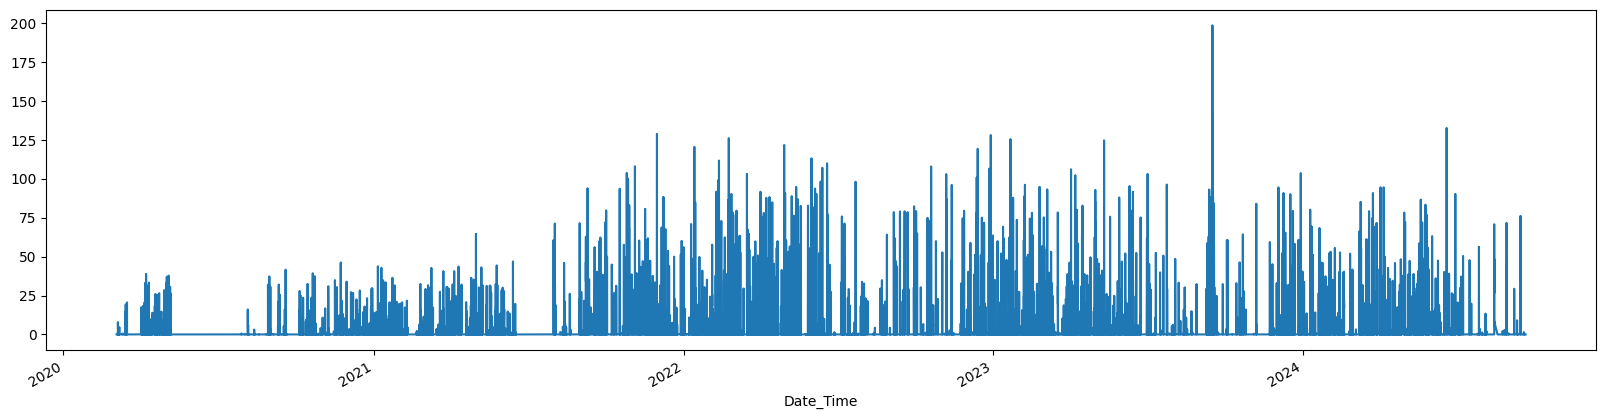

In [12]:
input_df['RI'].plot(figsize=(20, 5))

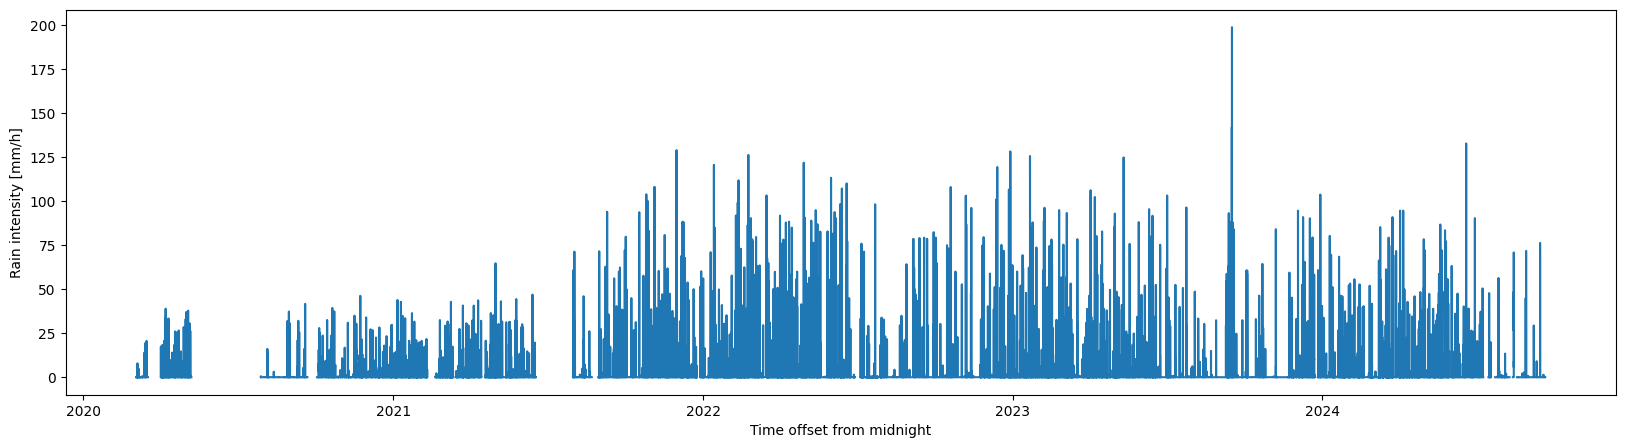

In [6]:
ouput_ds['rain_rate'].plot(figsize=(20, 5))